# GeoAI
## Prediction of Population Distribution with Random Forest Regressor

Required datasets (download from LearnIT): 
    
- raster_data : A folder including various raster layers about the study area
(GHS: population distrubution, mean building construction year and number of floors, housing prices of sold properties in 2018, mean prices of sold properties in the last decade, proximity to bus stations, railway stations, cultural spaces, schools, Corine land cover)

Take a look at the data and let's discuss!


In [ ]:
#Import modules
import os, pandas as pd, numpy as np
import rasterio as rs
# initial directory
cwd = os.getcwd()

In [ ]:
# Let's make a function to read a raster layer
def readRaster(file):
    src = rs.open(file)
    arr = src.read(1)
    arr = np.nan_to_num(arr, nan=0, posinf=0, neginf=0) 

    return arr

### Q: What are we doing here? 
<details>
<summary>
<font size="3" color="y">
<b>Optional hint for <code><font size="4"> changing dimensions</font></code></b>
</font>
</summary>

1. You'll find [flatten()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) useful!
</details>

In [ ]:
#     Steps:
        #       1) Provide the directory to raster_data.
        #       2) Change the dimensionality of the input layers
dataPath = ""

df = pd.DataFrame()
for i in os.listdir(dataPath):
    if i.endswith(".tif"):
        name = i.split(".tif")[0]
        arr = readRaster(dataPath + i)
        df["{}".format(name)] = arr
df.head(2)

Let's plot one of the input layers (e.g., GHS). First, plot its histogram, define the color scale and the bins, and finally plot and save the image

In [ ]:
#     Steps:
        #       1) Provide the directory to raster_data.
import matplotlib.pyplot as plt
from rasterio.plot import show_hist
plt.figure(figsize=(20, 10))
src = rs.open()
show_hist(src, bins=20, lw=0.0, stacked=False, alpha=0.5 ,title="Histogram")

In [ ]:
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# This function defines the bins for population distribution
def defineBins(valMin, valMax):
    valMax = int(round(valMax,1))
    valMin = int(round(valMin,1))
    bins = 7
    a=[valMin, 100, 200, 300, 400, 500, 600, valMax]
    colors_palette =["#f1eef6","#e0c8e2","#da9acb", "#df65b0", "#de348a", "#c61266","#980043"]
    cmap = ListedColormap(colors_palette )
    norm = colors.BoundaryNorm(a, bins)  
    # Add a legend for labels
    legend_labels = { colors_palette[0]: "<{1}".format(a[0], a[1]), colors_palette[1]: "{0}-{1}".format(a[1], a[2]), 
        colors_palette[2]: "{0}-{1}".format(a[2],a[3]), colors_palette[3]: "{0}-{1}".format(a[3],a[4]),
        colors_palette[4]: "{0}-{1}".format(a[4],a[5]), colors_palette[5]: "{0}-{1}".format(a[5],a[6]), 
        colors_palette[6]: ">{0}".format(a[6],a[7])}
    
    return cmap, norm, legend_labels

In [ ]:
# Let's plot the GHS layer and save it as an image
#     Steps:
        #       1) Provide the directory to Greater Copenhagen vector layer.
        #       2) Provide the directory to raster_data.
        #       3) Provide a map title.
        #       4) Provide a directory to save the image.
import geopandas as gpd
import rasterio.plot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(20, 20),facecolor='white') #50, 50

districtPath = ""
srcfile = gpd.read_file(districtPath, encoding ="latin-1" )
srcfile.plot(ax=ax, facecolor='none', edgecolor='#000000', linewidth=0.8,  zorder=2 )
src = rs.open()
arr = src.read(1)
arr = np.nan_to_num(arr, nan=0, posinf=0, neginf=0) 
valMax = np.round(np.max(arr), 2)
valMin = np.round(np.min(arr), 2)
#Define the color ramp and the legend
cmap, norm, legend_labels = defineBins(valMin, valMax)

waterTif = rasterio.open(cwd + "/data/raster_data/waterComb_cph_CLC_2012_2018.tif")
# colors for water layer
cmapWater = ListedColormap(["#00000000","#7fa9b060" ])
rasterio.plot.show(waterTif, ax=ax, cmap=cmapWater, zorder=5)
rasterio.plot.show(src, ax=ax, cmap=cmap, norm=norm, extent= [src.bounds[0],src.bounds[1], src.bounds[2], src.bounds[3]], zorder=1)  
srcfile['coords']= srcfile['geometry'].apply(lambda x: x.representative_point().coords[:])
srcfile['coords'] = [coords[0] for coords in srcfile['coords']]
for idx, row in srcfile.iterrows():
    plt.annotate(text = row['KOMNAVN'], xy=row['coords'], horizontalalignment= 'center', fontsize=12, zorder=20)

# Add a title
title = ""
ax.set_title(title, color="black", fontsize=18)
# Connect labels and colors, create legend and save the image
patches = [mpatches.Patch(color=color, label=label)
            for color, label in legend_labels.items()]     
       
ax.legend(handles=patches,  loc='lower right', facecolor="white", fontsize=12, title = 'Population', title_fontsize=14).set_zorder(6)
print("-----PLOTTING IMAGE {}-----".format(title))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
#plt.savefig(, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(),transparent=True)
plt.show()
plt.cla()
plt.close()

Play around with the color scale, move the legend to top right corner of the picture

In [ ]:
features=df.copy()

### Features and Targets
We need to separate the data into features and targets. The target, or label, is the value we want to predict, the population distribution. The features are the training data, or all the columns the model uses to make a prediction. We need to convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. How else could we have done it? 

In [ ]:
# Use numpy to convert to arrays
import numpy as np

#     Steps:
        #       1) Select the target column.
        #       2) Remove it from the training data.

# Labels are the values we want to predict
labels = np.array(features[])
# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop(, axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

### Training and Testing Sets
We are splitting the data into training and testing sets (75% of the dataset to train it and 25% to test). During the training, we let the model 'see' the answers, the population distribution, so it can learn how to predict it from the features. We suspect relationships between the features and the target values (higher population close to central points, no population in the sea), and the model’s job is to learn this relationship and the patterns during training. Then, when we evaluate the model, we make predictions on the testing set where it only has access to the features (not the answers)! As we have the actual answers for the test set, we can directly compare these predictions to the true value to judge how accurate the model is. Generally, when we train a model, we need to randomly split the data into training and testing sets to get a representation of all data points. However, it could also be trained in the whole dataset. I am setting the random state to 42 which means the results will be the same each time I run the split for reproducible results.

In [ ]:
from sklearn.model_selection import train_test_split

#     Steps:
        #       1) Select the percentage for splitting the dataset to training and testing set.
        
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

### Train Model
After all the work of data preparation, creating and training, the model is very simple using Scikit-learn. We import the random forest regression model from skicit-learn, instantiate the model, and fit (scikit-learn’s name for training) the model on the training data. We set the random state for reproducible results. This entire process is only 3 lines in scikit-learn!

In [ ]:
#     Steps:
        #       1) Select the number of trees and the depth of model. Recommended: 100, 6
        #       2) Select the training features and the target set.

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees and depth of 6
rf = RandomForestRegressor(n_estimators = , max_depth = , random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

### Make Predictions on the Training Set
Our model has now learnt the relationships between the features and the targets. The next step is to evaluate how good the model is! We make predictions on the test features and the model is not allowed to see the test answers. We then compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested to see how far away our average prediction is from the actual value so we take the absolute value.

In [ ]:
#     Steps:
        #       1) Make a prediction on the testing set 

# Use the forest's predict method on the test data
predictions = rf.predict()
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 1), 'persons.')

#### Q: What other evaluation metrics can we use? What do we need to know?

### Interpret Model and Report Results
At this point, we se that our model is not very good, but letøs try to understand how it works and why it fails. The question is: how does this model arrive at the values? There are two approaches to get under the hood of the random forest: 1. we can look at a single tree in the forest, 1. we can look at the feature importances of our explanatory variables.

Visualizing the Decision Trees

In [ ]:
# Import tools needed for visualization (you can skip thi step if you do not have pydot installed)
from sklearn.tree import export_graphviz
import pydot
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('data/small_tree.png')

Variable Importances

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Illustrate the relative significance of the variables (bar chart). 

Try to change the capacity of the model and its depth. 
How do the errors and the variable importances change? What if you remove the variables with the lowest importance? 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_feature_importance(importances,file):
    
    x_values = list(range(len(importances)))
   
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x_values, importances, orientation = 'vertical')
    plt.xticks(x_values, feature_list, rotation='vertical')
    #Add chart labels
    plt.title('Importance')
    plt.ylabel('FEATURE IMPORTANCE')
    plt.xlabel('Variables')
    plt.show()
    #plt.savefig(file, dpi=300, bbox_inches='tight')

In [ ]:
#     Steps:
        #       1) Plot the feature importances 


### Save and Visualize the Prediction
Let's use the whole dataset to make predictions and visualize it. 

In [ ]:
#     Steps:
        #       1) Make a prediction on the whole dataset
        #       2) Calculate the MAE
# Use the forest's predict method on the test data
predictions = rf.predict()
# Calculate the absolute errors
errors = abs(predictions - labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 1), 'persons.')

In [ ]:
#     Steps:
        #       1) Open the original GHS file
        #       2) Reshape the predictions to the GHS shape
        #       3) Give a destination file for the predictions
original_img = rs.open()
original_arr = original_img.read(1)
# Extract spatial metadata
input_crs = original_img.crs
input_gt  = original_img.transform

# Reshape the predictions
predictions = predictions.reshape(original_arr.shape[0],original_arr.shape[1] )

# Prepare output geotiff file. We give crs and gt read from input as spatial metadata
with rs.open(
  ,
  'w',
  driver = 'GTiff',
  count = 1,
  height = original_arr.shape[0],
  width  = original_arr.shape[1],
  dtype  = original_arr.dtype,
  crs    = input_crs,
  transform = input_gt  
) as output:
  output.write(predictions, 1)

Let's plot the predictions

0.02 2340.84


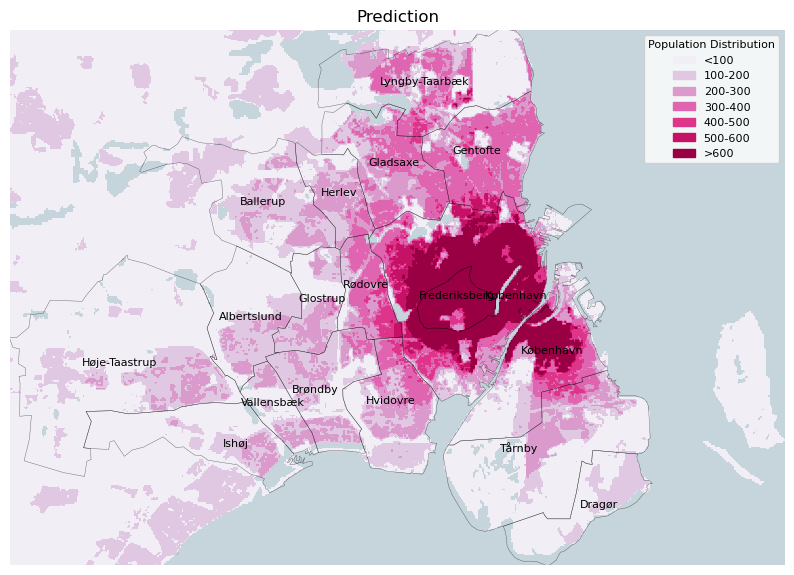

In [24]:
import geopandas as gpd
import rasterio.plot
#Read the predictions file
src = rs.open(cwd + "/prediction.tif")
pop = src.read(1)

valMax = np.round(np.max(pop), 2)
valMin = np.round(np.min(pop), 2)
print(valMin,valMax)
fig, ax = plt.subplots(figsize=(10, 10),facecolor='white') #50, 50
#Define the color ramp and the legend
cmap, norm, legend_labels = defineBins(valMin, valMax)

#Add municipality borders and names
kommune = gpd.read_file(cwd + "/data/GreaterCopenhagen.gpkg")
kommune.plot(ax=ax, facecolor='none', edgecolor='#000000', linewidth=.3, alpha=0.6, zorder=3 )
kommune['coords']= kommune['geometry'].apply(lambda x: x.representative_point().coords[:])
kommune['coords'] = [coords[0] for coords in kommune['coords']]
for idx, row in kommune.iterrows():
    plt.annotate(text = row['KOMNAVN'], xy=row['coords'], horizontalalignment= 'center', fontsize=8) 
xlim = ([kommune.total_bounds[0],  kommune.total_bounds[2]])
ylim = ([kommune.total_bounds[1],  kommune.total_bounds[3]])

#Add water
waterTif = rs.open(cwd + "/data/raster_data/waterComb_cph_CLC_2012_2018.tif")
# colors for water layer
cmapWater = ListedColormap(["#00000000","#7fa9b060" ])
rasterio.plot.show(waterTif, ax=ax, cmap=cmapWater, zorder=2)           
rasterio.plot.show(src, ax=ax, cmap=cmap, norm=norm, extent= [src.bounds[0],src.bounds[1], src.bounds[2], src.bounds[3]], zorder=1) 

patches = [mpatches.Patch(color=color, label=label)
                for color, label in legend_labels.items()] 
#Add legend
plt.legend(handles=patches,  loc='upper right', facecolor="white", fontsize=8, title = "Population Distribution", title_fontsize=8).set_zorder(4)
plt.axis("off")
plt.title("Prediction")
plt.savefig(cwd + "/prediction.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(),transparent=True)
plt.show()

(Advanced) Compare your prediction to the original data on a map